In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('Train_Data.csv')
test = pd.read_csv('Test_Data.csv')
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

train['is_train'] = 1
test['is_train'] = 0
test['age_group'] = np.nan

combined = pd.concat([train, test], ignore_index=True)

categorical_cols = ['RIAGENDR', 'PAQ605', 'DIQ010']
for col in categorical_cols:
    combined[col] = combined[col].fillna(combined[col].mode()[0])

numerical_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
for col in numerical_cols:
    combined[col] = combined[col].fillna(combined[col].median())

combined['RIAGENDR'] = combined['RIAGENDR'].map({1: 0, 2: 1})
combined['PAQ605'] = combined['PAQ605'].map({1: 1, 2: 0, 9: 0})
combined['DIQ010'] = combined['DIQ010'].map({1: 1, 2: 0, 3: 0.5, 7: 0.5, 9: 0.5})

combined.drop(columns='SEQN', inplace=True)

combined['BMI_category'] = pd.cut(
    combined['BMXBMI'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)
combined['BMI_category'] = combined['BMI_category'].map({
    'underweight': 0, 'normal': 1, 'overweight': 2, 'obese': 3
})

combined['GLU_INS_ratio'] = combined['LBXGLU'] / (combined['LBXIN'] + 1e-5)
combined['GLU_GLT_diff'] = combined['LBXGLU'] - combined['LBXGLT']
combined['GLU_GLT_ratio'] = combined['LBXGLU'] / (combined['LBXGLT'] + 1e-5)

combined['log_BMXBMI'] = np.log1p(combined['BMXBMI'])
combined['log_LBXIN'] = np.log1p(combined['LBXIN'])

combined['BMI_x_GLU'] = combined['BMXBMI'] * combined['LBXGLU']
combined['GLU_x_ACTIVITY'] = combined['LBXGLU'] * combined['PAQ605']

train_processed = combined[combined['is_train'] == 1].drop(columns='is_train')
test_processed = combined[combined['is_train'] == 0].drop(columns=['is_train', 'age_group'])

print("Train:", train_processed.shape)
print("Test :", test_processed.shape)

train_processed.head()



Train: (1966, 16)
Test : (312, 15)


,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group,BMI_category,GLU_INS_ratio,GLU_GLT_diff,GLU_GLT_ratio,log_BMXBMI,log_LBXIN,BMI_x_GLU,GLU_x_ACTIVITY
0,1,0.0,35.7,110.0,0.0,150.0,14.91,0.0,3,7.377594,-40.0,0.733333,3.602777,2.766948,3927.0,0.0
1,1,0.0,20.3,89.0,0.0,80.0,3.85,0.0,1,23.116823,9.0,1.112500,3.058707,1.578979,1806.7,0.0
2,0,0.0,23.2,89.0,0.0,68.0,6.14,0.0,1,14.495090,21.0,1.308823,3.186353,1.965713,2064.8,0.0
3,0,0.0,28.9,104.0,0.0,84.0,16.15,0.0,2,6.439624,20.0,1.238095,3.397858,2.841998,3005.6,0.0
4,1,1.0,35.9,103.0,0.0,81.0,10.92,0.0,3,9.432226,22.0,1.271605,3.608212,2.478218,3697.7,103.0


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       328
           1       0.30      0.37      0.33        63

    accuracy                           0.76       391
   macro avg       0.59      0.60      0.59       391
weighted avg       0.78      0.76      0.77       391



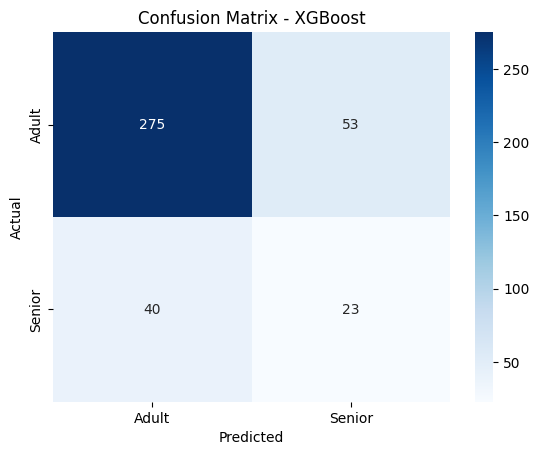

In [2]:
!pip install xgboost -q

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

drop_features = ['log_BMXBMI', 'log_LBXIN', 'BMI_category', 'DIQ010', 'PAQ605', 'RIAGENDR'] #low imp
X = train_processed.drop(columns=['age_group'] + drop_features)
y = train_processed['age_group'].dropna().astype(int)

X_y = pd.concat([X, y], axis=1).dropna()
X = X_y.drop(columns=['age_group'])
y = X_y['age_group'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=pos_weight,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)

print("Classification Report:\n")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred) #confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adult', 'Senior'], yticklabels=['Adult', 'Senior'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()
#tset set predict
X_test = test_processed.drop(columns=drop_features)
test_preds = xgb_model.predict(X_test).astype(int)


In [3]:
from sklearn.metrics import confusion_matrix

y_val_pred = xgb_model.predict(X_val)

val_results = X_val.copy()
val_results['actual'] = y_val.values
val_results['predicted'] = y_val_pred

misclassified = val_results[val_results['actual'] != val_results['predicted']] #miscalssified samples
print(f"Total Misclassified Samples: {len(misclassified)} / {len(val_results)}")

seniors_missed = misclassified[misclassified['actual'] == 1]
print(f"Seniors wrongly predicted as Adults: {len(seniors_missed)}")
seniors_missed.head(10)


Total Misclassified Samples: 93 / 391
Seniors wrongly predicted as Adults: 40


,BMXBMI,LBXGLU,LBXGLT,LBXIN,GLU_INS_ratio,GLU_GLT_diff,GLU_GLT_ratio,BMI_x_GLU,GLU_x_ACTIVITY,actual,predicted
1781,22.5,97.0,140.0,5.27,18.406037,-43.0,0.692857,2182.5,97.0,1,0
1936,44.0,81.0,74.0,21.46,3.774462,7.0,1.094594,3564.0,0.0,1,0
1736,25.9,102.0,56.0,8.04,12.686551,46.0,1.821428,2641.8,102.0,1,0
369,27.2,114.0,134.0,22.00,5.181816,-20.0,0.850746,3100.8,0.0,1,0
162,35.7,117.0,147.0,20.85,5.611508,-30.0,0.795918,4176.9,0.0,1,0
15,22.1,114.0,150.0,10.09,11.298304,-36.0,0.760000,2519.4,114.0,1,0
1414,28.1,112.0,110.0,14.94,7.496648,2.0,1.018182,3147.2,112.0,1,0
146,19.7,99.0,130.0,2.28,43.420862,-31.0,0.761538,1950.3,0.0,1,0
1801,25.8,105.0,128.0,20.37,5.154637,-23.0,0.820312,2709.0,0.0,1,0
1957,19.1,89.0,136.0,1.56,57.050916,-47.0,0.654412,1699.9,0.0,1,0


In [4]:
y_proba = xgb_model.predict_proba(X_val)

val_results['proba_0'] = y_proba[:, 0]  # Confidence for Adult
val_results['proba_1'] = y_proba[:, 1]  # Confidence for Senior

seniors_missed = val_results[(val_results['actual'] == 1) & (val_results['predicted'] == 0)]
seniors_missed[['proba_0', 'proba_1']].head(10)


,proba_0,proba_1
1781,0.808809,0.191191
1936,0.995998,0.004002
1736,0.917987,0.082013
369,0.553909,0.446091
162,0.748137,0.251863
15,0.644904,0.355096
1414,0.931402,0.068598
146,0.811698,0.188302
1801,0.689637,0.310363
1957,0.723887,0.276113


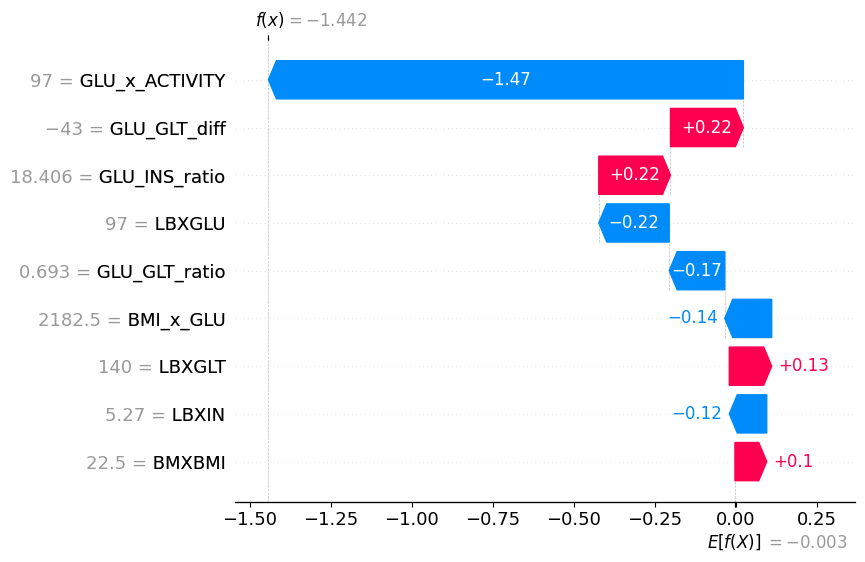

In [5]:
!pip install shap -q

import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)

sample_idx = X_val.index.get_indexer([seniors_missed.index[0]])[0]

shap.plots.waterfall(shap_values[sample_idx])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


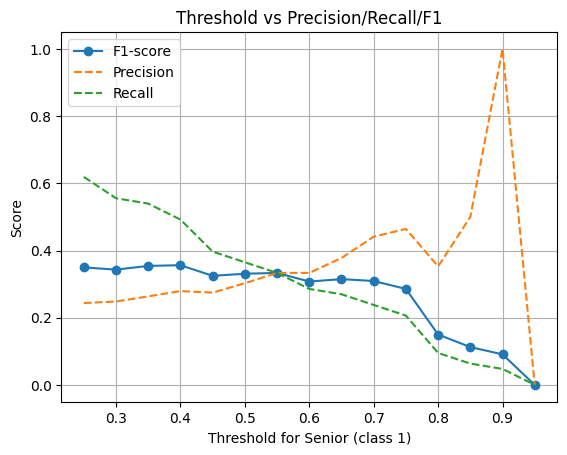

Best Threshold: 0.4 | F1: 0.356, Precision: 0.279, Recall: 0.492


In [6]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = [round(x * 0.05, 2) for x in range(5, 20)]  # 0.25 to 0.95

metrics = []

for t in thresholds:
    adjusted_preds = (val_results['proba_1'] > t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        val_results['actual'], adjusted_preds, average='binary', pos_label=1
    )
    metrics.append((t, p, r, f1))

threshold_df = pd.DataFrame(metrics, columns=['Threshold', 'Precision', 'Recall', 'F1'])


import matplotlib.pyplot as plt

plt.plot(threshold_df['Threshold'], threshold_df['F1'], label='F1-score', marker='o')
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision', linestyle='--')
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall', linestyle='--')
plt.xlabel('Threshold for Senior (class 1)')
plt.ylabel('Score')
plt.title('Threshold vs Precision/Recall/F1')
plt.legend()
plt.grid(True)
plt.show()

best_row = threshold_df.loc[threshold_df['F1'].idxmax()]
print(f"Best Threshold: {best_row['Threshold']} | F1: {best_row['F1']:.3f}, Precision: {best_row['Precision']:.3f}, Recall: {best_row['Recall']:.3f}")


In [7]:
test_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability of being Senior
final_preds = (test_probs > 0.4).astype(int)

submission_df = pd.DataFrame({'age_group': final_preds})
submission_df.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>